In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
from copy import deepcopy

In [5]:
# load iris data from sklearn
from sklearn.datasets import load_iris
iris = load_iris()
data = iris.data[:,:].astype(np.float32)
targ = iris.target.astype(np.int64)

In [6]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, targ, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, 
    X_val.shape, y_val.shape,
    X_test.shape, y_test.shape)

(108, 4) (108,) (12, 4) (12,) (30, 4) (30,)


In [8]:
from torch.utils.data import Dataset, DataLoader

# a Dataset class for pytorch. Dataset is a class for data loading and preprocessing
# it is used in conjunction with DataLoader class for batch processing
# Dataset class is a subclass of torch.utils.data.Dataset
# it has 3 methods: __init__, __getitem__, __len__
# __init__ is the constructor
# __getitem__ is used to get a sample from the dataset given an index
# __len__ is used to get the length of the dataset

# DataLoader is a class for batch processing
# it is used in conjunction with Dataset class
# DataLoader class is a subclass of torch.utils.data.DataLoader
# it has 3 methods: __init__, __iter__, __len__
# __init__ is the constructor
# __iter__ is used to iterate over the dataset
# __len__ is used to get the length of the dataset

class DataTrain(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.x = torch.from_numpy(X)
        self.y = torch.from_numpy(y).long()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.y)

class DataInference(Dataset):
    def __init__(self, X):
        self.x = torch.from_numpy(X)
    
    def __getitem__(self, index):
        return self.x[index]
    
    def __len__(self):
        return len(self.x)

In [9]:
# set batch size to 10, meaning that every 10 samples will be grouped together as a batch for processing
batch_size = 10

# create train and test data classes
train_data = DataTrain(X_train, y_train)
val_data = DataTrain(X_val, y_val)
test_data = DataTrain(X_test, y_test)
#test_data = data_inference(X_test)

# instantiate data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# print out the shapes of the data
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

108 12 30


In [31]:
# build neural network class
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # define layers
        self.fc1 = nn.Linear(input_dim, 10)
        self.output = nn.Linear(10, output_dim)

    def forward(self, x):
        # define forward pass of data through the network including activation functions
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

In [41]:
def train(model, train_loader, optimizer, objective, device):
    model.train()
    train_batch_loss = []
    train_batch_acc = []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        n = y.size(0)
        optimizer.zero_grad()
        y_hat = model(x)
        label = y_hat.argmax(dim=1)
        loss = objective(y_hat, y)
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item())
        train_batch_acc.append((label == y).sum().item() / n)

    train_loss = sum(train_batch_loss) / len(train_batch_loss)
    train_acc = sum(train_batch_acc) / len(train_batch_acc)

    return train_loss, train_acc


def validate(model, val_loader, objective, device):
    model.eval()
    val_batch_loss = []
    val_batch_acc = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            n = y_val.size(0)
            y_hat_val = model(x_val)
            label = y_hat_val.argmax(dim=1)
            loss_val = objective(y_hat_val, y_val)
            val_batch_loss.append(loss_val.item())
            val_batch_acc.append((label == y_val).sum().item() / n)

    val_loss = sum(val_batch_loss) / len(val_batch_loss)
    val_acc = sum(val_batch_acc) / len(val_batch_acc)

    return val_loss, val_acc

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    accuracy = []
    with torch.no_grad():
        for x_test, y_test in data_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            y_hat = model(x_test)
            label = y_hat.argmax(dim=1)
            predictions.append(label)
            accuracy.append((label == y_test).sum().item() / len(y_test))
    accuracy = sum(accuracy) / len(accuracy)
    return predictions, accuracy

def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            n = x.size(0)
            y_hat = model(x)
            label = y_hat.argmax(dim=1)
            predictions.append(label)

    return predictions

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')
        self.best_model_weights = None

    def early_stop(self, validation_loss, model):
        print(f"Early Stopping counter: {self.counter} out of {self.patience}")
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 1
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [33]:
# lists to store loss and accuracy
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# training lists and parameters
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate model, loss function and optimizer
model = NeuralNet(X_train.shape[1], 3).to(device)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

for epoch in range(n_epochs):
    tr_loss, tr_acc = train(model, train_loader, optimizer, objective, device)
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)

    eva_loss, eva_acc = validate(model, val_loader, objective, device)
    val_loss.append(eva_loss)
    val_acc.append(eva_acc)
    print(f'[{epoch+1}/{n_epochs}] Train loss: {tr_loss:.4f} acc: {tr_acc*100:.2f}% - Val loss: {eva_loss:.4f} acc: {eva_acc*100:.2f}%')
    if early_stopper.early_stop(val_loss, model):
        early_stopper.save_best_weights(model)
        print("Patience Depleated: Early Stopping triggered.")
        break


[1/100] Train loss: 0.9853 acc: 57.73% - Val loss: 1.0008 acc: 55.00%
[2/100] Train loss: 0.8871 acc: 66.59% - Val loss: 1.2015 acc: 35.00%
[3/100] Train loss: 0.8549 acc: 70.68% - Val loss: 0.7687 acc: 85.00%
[4/100] Train loss: 0.7426 acc: 82.73% - Val loss: 0.6998 acc: 95.00%
[5/100] Train loss: 0.6891 acc: 89.09% - Val loss: 0.9225 acc: 65.00%
[6/100] Train loss: 0.6334 acc: 96.36% - Val loss: 0.6244 acc: 95.00%
[7/100] Train loss: 0.7336 acc: 82.50% - Val loss: 0.7740 acc: 80.00%
[8/100] Train loss: 0.8933 acc: 66.82% - Val loss: 0.9566 acc: 60.00%
[9/100] Train loss: 0.8840 acc: 67.05% - Val loss: 0.9516 acc: 60.00%
[10/100] Train loss: 0.8813 acc: 67.27% - Val loss: 0.9522 acc: 60.00%
[11/100] Train loss: 0.8807 acc: 67.73% - Val loss: 1.1546 acc: 40.00%
Early stopping triggered.


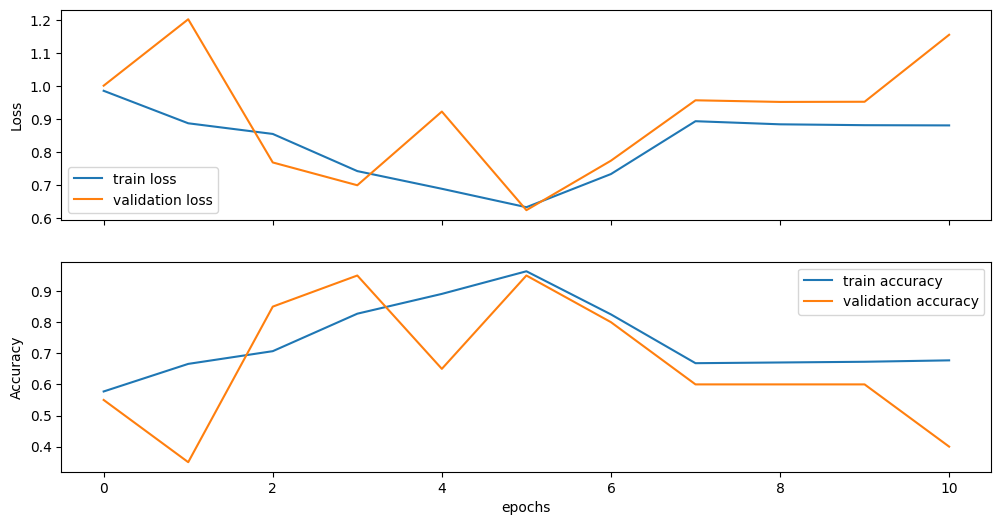

In [34]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

# Copy the tensors from GPU to CPU
train_loss_cpu = torch.Tensor(train_loss).cpu().tolist()
val_loss_cpu = torch.Tensor(val_loss).cpu().tolist()
train_acc_cpu = torch.Tensor(train_acc).cpu().tolist()
val_acc_cpu = torch.Tensor(val_acc).cpu().tolist()

ax1.plot(train_loss_cpu, label="train loss")
ax1.plot(val_loss_cpu, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_acc_cpu, label="train accuracy")
ax2.plot(val_acc_cpu, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()

In [49]:
# predict on test data
predictions, accuracy = evaluate(model, test_loader, device)
print(f"Accuracy on test data: {accuracy*100:.2f}%")
print(f"The predictions are: {predictions}")

Accuracy on test data: 63.33%
The predictions are: [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0'), tensor([1, 0, 1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')]


In [23]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0214, -0.4756,  1.2374,  0.8367],
        [ 0.6857,  0.8896, -0.7868, -1.0759],
        [-0.0270, -0.0577,  0.0029, -0.0475],
        [-0.2912, -0.4647,  0.6349,  0.4045],
        [-0.0591, -0.0330, -0.0799, -0.0233],
        [-0.0206, -0.0273, -0.0190, -0.0345],
        [-0.0277, -0.0310, -0.0144,  0.0053],
        [ 0.5071,  0.7158, -0.7132, -0.6972],
        [ 0.3975,  0.5034, -0.6014, -0.3761],
        [-0.3038, -0.0821, -0.2615,  0.0532]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-1.4838e-01,  5.3569e-01,  5.2792e-04, -2.1222e-01,  7.6662e-03,
        -2.1261e-02,  8.7507e-03,  3.0639e-01,  1.4826e-01,  8.4237e-02],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-1.2607,  0.8382, -0.0016, -0.1231,  0.0461, -0.0546,  0.0024,  0.7152,
          0.5020,  0.0060],
        [ 0.1640,  0.6300,  0.2897, -0.2257, -0.0116, -0.0073,  0.0268,  0.2371,
          0.0187, -0.0700],
        [ 0.9515, -1